In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
#http://biopython.org/DIST/docs/tutorial/Tutorial.html
#https://biopython.org/wiki/SeqIO
from Bio import Seq, SeqIO

#http://biopython.org/DIST/docs/api/Bio.Alphabet-module.html
from Bio.Alphabet import generic_dna

#https://docs.python.org/3/library/itertools.html
import itertools

In [ ]:
import keras
from keras.layers import Dense, Dropout, Conv1D
from keras.models import Model, Sequential
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Concatenate, LeakyReLU, concatenate, MaxPool1D,GlobalMaxPool1D,add
from keras.layers import Dense, Embedding, Input, Masking, Dropout, MaxPooling1D,Lambda, BatchNormalization
from keras.layers import LSTM, TimeDistributed, AveragePooling1D, Flatten,Activation,ZeroPadding1D, UpSampling1D
from keras.optimizers import Adam, rmsprop
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint, CSVLogger
from keras.layers import Conv1D, GlobalMaxPooling1D, ConvLSTM2D, Bidirectional,RepeatVector
from keras import regularizers
from keras.utils import plot_model, to_categorical
from keras.preprocessing.text import Tokenizer

In [6]:
df = pd.read_csv('./NuclearCytosolLncRNAs_ALL_8mer_stride1_tokens.csv.count.csv',index_col=0)

In [7]:
df.head()

,class,tttttttt,aaaaaaaa,ccaggctg,caggctgg,cacacaca,acacacac,cagcctcc,aaaataaa,aaataaaa,...,ctcaggag,ctgtcacc,ctccagaa,gaaatgaa,agccaggc,agatgaag,ctggagcc,tgcctggg,tggagaga,gagatggg
name,,,,,,,,,,,,,,,,,,,,,
ENST00000446717.5,Nuclear,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ENST00000603052.1,Nuclear,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENST00000608561.1,Nuclear,0,0,1,1,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENST00000627496.2,Nuclear,0,0,1,0,0,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENST00000423499.3,Nuclear,11,6,1,1,0,0,1,0,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
def fasta_2_csv(path):
    #Reading a fasta database as a panda dataframe
    reads=[]
    for record in SeqIO.parse(path, "fasta"):
        id_ = record.description.split(' ')[0]
        seq_ = str(record.seq)
        reads.append([id_,seq_,len(record.seq)])    
    df = pd.DataFrame(reads,columns=['id','seq','len'])
    # Applying encoding
    #df['encoded'] = df['seq'].apply(encode_nu)
    return df

In [ ]:
fasta_df = fasta_2_csv('./lncRNA_amanda.fasta')

In [91]:
fasta_df.head()

,id,seq,len
0,ENST00000473358.1,GTGCACACGGCTCCCATGCGTTGTCTTCCGAGCGTCAGGCCGCCCC...,712
1,ENST00000461467.1,GGGGTTTCGGGGCTGTGGACCCTGTGCCAGGAAAGGAAGGGCGCAG...,590
2,ENST00000495576.1,TCAGCCTCCCAAGTAGCTGGGGCTACAGGCACCTGCCACCAAACCC...,1319
3,ENST00000471248.1,GAAGCTCGAGGAAGAGAAAAAAAAACTGGAAGGAGAAATCATAGAT...,629
4,ENST00000484859.1,GCCATTTCTTTTTTTTCTTTTTTTTTTTAAGATAAGAGTCTTTCTC...,4860


In [92]:
## Map the classes from df to fasta_df
fasta_df.index = fasta_df['id']
df['id'] = df.index
fasta_df['class'] = fasta_df['id'].map(df.set_index('id')['class'])

In [93]:
# Dropping any rows with NAin the class 
fasta_df = fasta_df.dropna()

In [94]:
fasta_df.head()

,id,seq,len,class
id,,,,
ENST00000466557.6,ENST00000466557.6,ATGATGATTATTCCCCACCTTCTAAGAGACAAAGACCAACGAGCCA...,1301,Nuclear
ENST00000450983.1,ENST00000450983.1,TACGGCAGCTTTAGGGAGGTGCTCTGAGACCCGAAACTAGACTCGA...,607,Cytosol
ENST00000623070.3,ENST00000623070.3,GTGTCTGCGTCGGGTTCTGTTGGAGTGCGTTCGGTGCGCCGTGGGT...,494,Nuclear
ENST00000425657.1,ENST00000425657.1,GTCTCAGCCAGCAGGGTTGCCCAGTGCCCCTTGTCACCCCCCGAGC...,845,Nuclear
ENST00000606034.1,ENST00000606034.1,TCCCAACTGGGGCCGAGTTCACCAGGGCCCACGGGAGGCGAGCGAG...,2086,Nuclear


In [95]:
df.shape

(1999, 258)

In [96]:
fasta_df.shape

(1999, 4)

In [97]:
# convert the classes to 0 and 1
fasta_df['class'] = pd.factorize(fasta_df['class'])[0]

### Kmer Based Modeling


https://www.cs.helsinki.fi/u/tpkarkka/teach/16-17/MAiB/kMerStatistics.html

In [ ]:
# Strtify sample to train , test and validation data
X=fasta_df.drop(columns=['class','id','len'])
y=fasta_df.loc[:,'class']
train, test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=15)
#train, valid, y_train, y_valid = train_test_split(train,y_train,test_size=0.15, random_state=15)

In [99]:
from sklearn.feature_extraction.text import CountVectorizer
KMER_SIZE = 7
counter = CountVectorizer(input='content',#vocabulary=int_to_word,
                          analyzer='char',ngram_range=(KMER_SIZE,KMER_SIZE),
                          lowercase=False)

In [100]:
counter.fit(train.seq.values.tolist())
X_train = counter.transform(train.seq.values.tolist())
X_test = counter.transform(test.seq.values.tolist())
#X_valid = counter.transform(valid.seq.values.tolist())

In [101]:
len(counter.vocabulary_)

16384

In [102]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.decomposition import SparsePCA,PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.feature_selection import VarianceThreshold
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Bidirectional,Embedding, MaxPooling1D, BatchNormalization
from keras.layers import Conv1D, AveragePooling1D, concatenate,GlobalMaxPool1D,LSTM
from keras.layers import GRU, Flatten, TimeDistributed, SpatialDropout1D, GlobalMaxPooling1D, Masking,Activation,GRU
from keras.optimizers import rmsprop, adam

In [103]:
# A pipeline is a list of preprocessing steps in one command
# first we will remove high correlated features
# then we will apply scaling as neural network needs values frm 0 to 1
pipeline = Pipeline([#('corr-removal',VarianceThreshold(0.8)),
                     #('selector',SelectKBest(chi2,500)),
                     #('pca',PCA()),
                     ('scaler',MaxAbsScaler())
])

In [104]:
# Applying the pipeline
x_train = pipeline.fit_transform(X_train.toarray(),y_train)
# notice that the pipeline learn the best parameters fro the tarin data only to apply to test ana valiadation data
x_test = pipeline.transform(X_test.toarray())
#x_valid = pipeline.transform(X_valid.toarray())

In [105]:
x_train.shape

(1599, 16384)

In [106]:
# Testing some simple ML

In [107]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

In [108]:
### Random Hyperparameter search
# I didn't used any internal valiadtion as the next algorithms uses cross validation cv =10
cv = 5
n_iter = 5
n_jobs= -1

In [109]:
clf = RandomForestClassifier(random_state=0)
parameters = {'n_estimators':(10,20,30,40,50,60),
              'max_features': (10,20,8,5,'auto'),
              'max_depth':(5,20,50,100,500,250,20,10)}
clf= RandomizedSearchCV(clf, parameters,cv=cv,n_jobs=n_jobs,n_iter=n_iter)
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
accuracy_score(pred,y_test)

0.6075

In [110]:
clf = LogisticRegression(random_state=0)
parameters = {'C':(0.3,0.5,0.55,0.6,0.75),
              'tol': (0.0002,0.0004,.0005)}
#clf = RandomizedSearchCV(clf, parameters,cv=cv,n_jobs=n_jobs,n_iter=n_iter)
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
accuracy_score(pred,y_test)

/home/biohacker2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.645

### tpot apply genetic algorithm for hyper parameter optimization

In [58]:
# it takes alot of time
# you will need to install tpot first pip install tpot

In [112]:
from tpot import TPOTClassifier
tpot = TPOTClassifier(verbosity=2,cv=10,#config_dict=tpot_config,#max_time_mins=10,
 scoring='accuracy', 
 random_state=0, 
 periodic_checkpoint_folder='tpot_results.txt', 
 n_jobs=-1, 
 generations=50, 
 population_size=10,
 early_stop = 5)
tpot.fit(x_train,y_train)

Generation 1 - Current best internal CV score: 0.6310232577444432
Generation 2 - Current best internal CV score: 0.6310232577444432
Generation 3 - Current best internal CV score: 0.6310232577444432
Generation 4 - Current best internal CV score: 0.6310232577444432
Generation 5 - Current best internal CV score: 0.6310232577444432

The optimized pipeline was not improved after evaluating 5 more generations. Will end the optimization process.

TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: LogisticRegression(input_matrix, C=0.1, dual=False, penalty=l2)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=10,
        disable_update_check=False, early_stop=5, generations=50,
        max_eval_time_mins=5, max_time_mins=None, memory=None,
        mutation_rate=0.9, n_jobs=-1, offspring_size=None,
        periodic_checkpoint_folder='tpot_results.txt', population_size=10,
        random_state=0, scoring='accuracy', subsample=1.0, use_dask=False,
        verbosity=2, warm_start=False)

In [113]:
y_hat_train = tpot.predict(x_train)
train_acc = accuracy_score(y_train,y_hat_train)
print("Train set Accuracy for ensemble: " + str(train_acc))

y_pred = tpot.predict(x_test)
test_acc = accuracy_score(y_test,y_pred) 
print("Test Set Accuracy for ensemble: " + str(test_acc))

Train set Accuracy for ensemble: 0.99812382739212
Test Set Accuracy for ensemble: 0.66


### Sequence Based Classifier

In [118]:
# Convert a sequence of charaters to a sequence of kmers
def seq_to_kmer(seq):
    return ' '.join([seq[i:i+KMER_SIZE] for i in range(len(seq)-KMER_SIZE)]).lower()

In [119]:
KMER_SIZE= 6

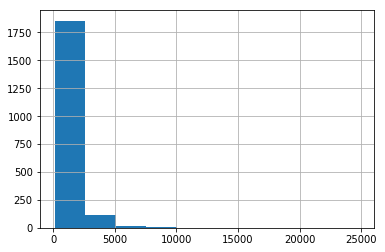

In [120]:
## As some sequence are very long which may cause overfitting for small sequences
# We will determine a cutoff based on standard deviation
fasta_df.len.hist()

In [121]:
max_len = int(fasta_df.len.std()*2)
fasta_df['seq_cutted'] = fasta_df['seq'].apply(lambda x: x[0:max_len])

In [122]:
fasta_df['kmers'] = fasta_df['seq_cutted'].apply(lambda x: seq_to_kmer(x))

In [123]:
fasta_df.head()

,id,seq,len,class,seq_cutted,kmers
id,,,,,,
ENST00000466557.6,ENST00000466557.6,ATGATGATTATTCCCCACCTTCTAAGAGACAAAGACCAACGAGCCA...,1301,0,ATGATGATTATTCCCCACCTTCTAAGAGACAAAGACCAACGAGCCA...,atgatg tgatga gatgat atgatt tgatta gattat atta...
ENST00000450983.1,ENST00000450983.1,TACGGCAGCTTTAGGGAGGTGCTCTGAGACCCGAAACTAGACTCGA...,607,1,TACGGCAGCTTTAGGGAGGTGCTCTGAGACCCGAAACTAGACTCGA...,tacggc acggca cggcag ggcagc gcagct cagctt agct...
ENST00000623070.3,ENST00000623070.3,GTGTCTGCGTCGGGTTCTGTTGGAGTGCGTTCGGTGCGCCGTGGGT...,494,0,GTGTCTGCGTCGGGTTCTGTTGGAGTGCGTTCGGTGCGCCGTGGGT...,gtgtct tgtctg gtctgc tctgcg ctgcgt tgcgtc gcgt...
ENST00000425657.1,ENST00000425657.1,GTCTCAGCCAGCAGGGTTGCCCAGTGCCCCTTGTCACCCCCCGAGC...,845,0,GTCTCAGCCAGCAGGGTTGCCCAGTGCCCCTTGTCACCCCCCGAGC...,gtctca tctcag ctcagc tcagcc cagcca agccag gcca...
ENST00000606034.1,ENST00000606034.1,TCCCAACTGGGGCCGAGTTCACCAGGGCCCACGGGAGGCGAGCGAG...,2086,0,TCCCAACTGGGGCCGAGTTCACCAGGGCCCACGGGAGGCGAGCGAG...,tcccaa cccaac ccaact caactg aactgg actggg ctgg...


In [124]:
# Strtify sample to train , test and validation data
# Validation data is important for neural network backpropagation
X=fasta_df.drop(columns=['class','id','len','seq','seq_cutted'])
y=fasta_df.loc[:,'class']
train, test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=15)
# The test data is the same but we take the validatin data from the train
train, val, y_train, y_val = train_test_split(train,y_train,test_size=0.15, random_state=15)

In [125]:
# Tokenizing
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(train.values.tolist())
X_train = tokenizer.texts_to_sequences(train.values.tolist())
X_test = tokenizer.texts_to_sequences(test.values.tolist())
X_val = tokenizer.texts_to_sequences(val.values.tolist())
# Padding the sequence of vectors with zeros
X_train = pad_sequences(X_train,maxlen = max_len)
X_test = pad_sequences(X_test,maxlen = max_len )
X_val = pad_sequences(X_val,maxlen = max_len )

In [126]:
X_train.shape

(1359, 2811)

In [127]:
max_features = X_train.max() + 1

In [128]:
#Converting the output to categorical classes
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
Y_val = to_categorical(y_val)

In [129]:
#calculate class weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(Y_train.argmax(-1)),
                                                  Y_train.argmax(-1))

In [114]:
def build_lstm_classifier(bidirectional, add_attention,trained_embedding):
    inp1 = Input(shape=(X_train.shape[1],),dtype='uint16')    
    if trained_embedding:
        emb = embedding
        main = emb(inp1)
    else:
        main = Embedding(max_features,120)(inp1)

    if bidirectional ==True and add_attention ==False:
        main = Bidirectional(LSTM(16, return_sequences=False))(main)
     
    elif add_attention ==True:
        main = Bidirectional(LSTM(16, return_sequences=True))(main)
        main = Attention_layer()(main)     
    else:
        main = LSTM(16, return_sequences=False)(main)
        
    main = Activation('relu')(main)
    main = BatchNormalization()(main)
    main = Dropout(0.5)(main)
    main = Dense(128)(main) 
    main = Dropout(0.5)(main)
    main = Dense(64)(main) 
    main = Dropout(0.5)(main)
    main = BatchNormalization()(main)
    out = Dense(2,activation='sigmoid')(main)
    
    model = Model(inputs=[inp1], outputs=[out])
    optimizer = adam(0.001,amsgrad=True)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,metrics=['accuracy'])
    return model

In [116]:
## Attention Implementation in Keras by https://github.com/BITDM/bitdm.github.io
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

class Attention_layer(Layer):
    """
        Attention operation, with a context/query vector, for temporal data.
        Supports Masking.
        Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
        "Hierarchical Attention Networks for Document Classification"
        by using a context vector to assist the attention
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (LSTM/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(AttentionWithContext())
        """

    def __init__(self,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(Attention_layer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        super(Attention_layer, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = K.dot(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)

        a = K.exp(uit)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [130]:
# LSTM Model
batch_size = 32
model = build_lstm_classifier(bidirectional=False,add_attention=False,trained_embedding=False)
checkpoint = ModelCheckpoint(filepath='LSTM.hdfs', save_weights_only=True,
                             monitor='val_loss',save_best_only=True)
EarlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5,
                          verbose=0, mode='auto')
#model.load_weights('2input_BiLSTM.hdfs')

RL = ReduceLROnPlateau(min_lr=0.00001,factor=0.3,patience=2)

model.fit(X_train,Y_train,callbacks=[checkpoint,RL,EarlyStop],class_weight=class_weights,
          validation_data=[X_val, Y_val],
          epochs=50,
          batch_size=batch_size, 
          verbose=2)
model.load_weights('LSTM.hdfs')
acc = model.evaluate(X_test,Y_test)[1]
print('LSTM Model Accuracy : '+ str(acc))

Train on 1359 samples, validate on 240 samples
Epoch 1/50
 - 88s - loss: 0.8487 - acc: 0.4985 - val_loss: 0.6986 - val_acc: 0.4167
Epoch 2/50
 - 75s - loss: 0.7966 - acc: 0.5011 - val_loss: 0.7800 - val_acc: 0.4167
Epoch 3/50
 - 84s - loss: 0.6822 - acc: 0.6100 - val_loss: 0.7786 - val_acc: 0.4167
Epoch 4/50
 - 80s - loss: 0.5403 - acc: 0.7152 - val_loss: 0.8414 - val_acc: 0.4167
Epoch 5/50
 - 82s - loss: 0.4484 - acc: 0.7896 - val_loss: 0.8447 - val_acc: 0.4167
Epoch 6/50
 - 86s - loss: 0.3862 - acc: 0.8322 - val_loss: 0.8389 - val_acc: 0.4167
400/400 [==============================] - 5s 13ms/step
LSTM Model Accuracy : 0.495


In [131]:
# Bidirectional LSTM Model
batch_size = 32
model = build_lstm_classifier(bidirectional=True,add_attention=False,trained_embedding=False)
checkpoint = ModelCheckpoint(filepath='Bi_LSTM.hdfs', save_weights_only=True,
                             monitor='val_loss',save_best_only=True)
EarlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5,
                          verbose=0, mode='auto')
RL = ReduceLROnPlateau(min_lr=0.00001,factor=0.3,patience=2)

model.fit(X_train,Y_train,callbacks=[checkpoint,RL,EarlyStop],class_weight=class_weights,
          validation_data=[X_val, Y_val],
          epochs=50,
          batch_size=batch_size, 
          verbose=2)
model.load_weights('Bi_LSTM.hdfs')
acc = model.evaluate(X_test,Y_test)[1]
print('LSTM Model Accuracy : '+ str(acc))

Train on 1359 samples, validate on 240 samples
Epoch 1/50
 - 165s - loss: 0.8817 - acc: 0.4941 - val_loss: 0.6991 - val_acc: 0.4167
Epoch 2/50
 - 196s - loss: 0.8288 - acc: 0.5070 - val_loss: 0.7165 - val_acc: 0.4167
Epoch 3/50
 - 136s - loss: 0.7776 - acc: 0.5298 - val_loss: 0.6819 - val_acc: 0.5833
Epoch 4/50
 - 152s - loss: 0.6709 - acc: 0.6229 - val_loss: 0.6989 - val_acc: 0.4167
Epoch 5/50
 - 147s - loss: 0.4615 - acc: 0.7859 - val_loss: 0.6911 - val_acc: 0.5000
Epoch 6/50
 - 175s - loss: 0.2955 - acc: 0.8830 - val_loss: 0.7912 - val_acc: 0.4167
Epoch 7/50
 - 175s - loss: 0.2335 - acc: 0.9227 - val_loss: 0.7900 - val_acc: 0.4167
Epoch 8/50
 - 156s - loss: 0.1968 - acc: 0.9393 - val_loss: 0.7258 - val_acc: 0.4167
400/400 [==============================] - 9s 23ms/step
LSTM Model Accuracy : 0.505


In [132]:
# Bidirectional LSTM + Attention Model
batch_size = 32
model = build_lstm_classifier(bidirectional=True,add_attention=True,trained_embedding=False)
checkpoint = ModelCheckpoint(filepath='Attention_Bi_LSTM.hdfs', save_weights_only=True,
                             monitor='val_loss',save_best_only=True)
EarlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5,
                          verbose=0, mode='auto')
RL = ReduceLROnPlateau(min_lr=0.00001,factor=0.3,patience=2)

model.fit(X_train,Y_train,callbacks=[checkpoint,RL,EarlyStop],class_weight=class_weights,
          validation_data=[X_val, Y_val],
          epochs=50,
          batch_size=batch_size, 
          verbose=2)
model.load_weights('Attention_Bi_LSTM.hdfs')
acc = model.evaluate(X_test,Y_test)[1]
print('Attention_Bi_LSTM Model Accuracy : '+ str(acc))

Train on 1359 samples, validate on 240 samples
Epoch 1/50
 - 159s - loss: 0.7223 - acc: 0.4937 - val_loss: 0.6974 - val_acc: 0.5833
Epoch 2/50
 - 169s - loss: 0.7208 - acc: 0.4812 - val_loss: 0.7334 - val_acc: 0.5000
Epoch 3/50
 - 176s - loss: 0.7098 - acc: 0.5202 - val_loss: 1.6002 - val_acc: 0.5833
Epoch 4/50
 - 184s - loss: 0.6951 - acc: 0.5298 - val_loss: 6.6793 - val_acc: 0.5833
Epoch 5/50
 - 162s - loss: 0.6512 - acc: 0.6207 - val_loss: 6.6793 - val_acc: 0.5833
Epoch 6/50
 - 151s - loss: 0.4846 - acc: 0.8079 - val_loss: 6.6793 - val_acc: 0.5833
400/400 [==============================] - 9s 23ms/step
Attention_Bi_LSTM Model Accuracy : 0.505


In [62]:
# Buid the MLP neural network 
def build_mlp_classifier():
    #the input must have the number of features
    inp1 = Input(shape=(X_train.shape[1],),dtype='float')
    emb =Embedding(max_features,120)(inp1)
    main = Dense(64)(emb)
    # Dropouts are important t prevent the overfitting
    main = Dropout(0.5)(main)
    # Batch normalization allow faster convergence
    main = BatchNormalization()(main)
    main = Dense(64)(main)  
    main = Dropout(0.5)(main)
    main = BatchNormalization()(main)
    main = GlobalMaxPooling1D()(main)
    main = Dense(32)(main)  
    #main = Dropout(0.5)(main)
    #main = Dense(256)(main)  
    #main = Dropout(0.5)(main)
    # Simoid function is a must in binary classification
    out = Dense(2,activation='sigmoid')(main)
    model = Model(inputs=[inp1], outputs=[out])
    # Slower leraning rate is important in small dataset < 0.001
    optimizer = Adam(lr=0.001)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,metrics=['accuracy'])
    return model

In [63]:
# MLP_sequence_based
batch_size = 32
model = build_mlp_classifier()
checkpoint = ModelCheckpoint(filepath='MLP_sequence_based.hdfs', save_weights_only=True,
                             monitor='val_loss',save_best_only=True)
EarlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5,
                          verbose=0, mode='auto')
RL = ReduceLROnPlateau(min_lr=0.00001,factor=0.3,patience=2)

model.fit(X_train,Y_train,callbacks=[checkpoint,RL,EarlyStop],class_weight=class_weights,
          validation_data=[X_val, Y_val],
          epochs=50,
          batch_size=batch_size, 
          verbose=2)
model.load_weights('MLP_sequence_based.hdfs')
acc = model.evaluate(X_test,Y_test)[1]
print('MLP_sequence_based Model Accuracy : '+ str(acc))

Train on 1359 samples, validate on 240 samples
Epoch 1/50
 - 37s - loss: 0.8657 - acc: 0.5118 - val_loss: 0.6866 - val_acc: 0.5000
Epoch 2/50
 - 34s - loss: 0.7531 - acc: 0.4930 - val_loss: 0.6944 - val_acc: 0.5000
Epoch 3/50
 - 33s - loss: 0.7569 - acc: 0.4941 - val_loss: 0.6919 - val_acc: 0.5000
Epoch 4/50
 - 34s - loss: 0.7368 - acc: 0.4982 - val_loss: 0.6899 - val_acc: 0.5000
Epoch 5/50
 - 33s - loss: 0.7419 - acc: 0.4923 - val_loss: 0.6894 - val_acc: 0.5000
Epoch 6/50
 - 34s - loss: 0.7286 - acc: 0.5132 - val_loss: 0.6856 - val_acc: 0.5833
Epoch 7/50
 - 33s - loss: 0.7270 - acc: 0.5151 - val_loss: 0.6850 - val_acc: 0.5833
Epoch 8/50
 - 34s - loss: 0.7232 - acc: 0.5132 - val_loss: 0.6866 - val_acc: 0.5833
Epoch 9/50
 - 35s - loss: 0.7314 - acc: 0.5184 - val_loss: 0.6877 - val_acc: 0.5833
Epoch 10/50
 - 36s - loss: 0.7186 - acc: 0.5258 - val_loss: 0.6890 - val_acc: 0.5833
Epoch 11/50
 - 36s - loss: 0.7115 - acc: 0.5397 - val_loss: 0.6897 - val_acc: 0.5833
Epoch 12/50
 - 35s - loss: 

### Word2Vec

In [133]:
# Loading Google W2V will take a lot of memory
from gensim.models import  KeyedVectors,Word2Vec 
import multiprocessing

# Gensim Word2Vec model
def get_embedding(x_array,tokenizer,max_features):
    # Function for getting word2ve ang keras embedding layer
    df = pd.DataFrame()
    df['x'] = tokenizer.sequences_to_texts(x_array)
    corpus = df['x'].apply(lambda x: x.split(' '))

    # Create Word2Vec
    word2vec = Word2Vec(sentences=corpus,
                        #size=120,#max_vocab_size=max_features,
                        hs=1,
                        seed=1,
                        workers=multiprocessing.cpu_count())
    embedding = word2vec.wv.get_keras_embedding(train_embeddings=False)
    return word2vec, embedding

In [134]:
#  Getting the embedding from the word2vec
word2vec,embedding = get_embedding(X_train,tokenizer,max_features)
word2vec.save("text_word2vec.model")

In [73]:
embedding.weights

[]

In [135]:
# LSTM Model
batch_size = 32
model = build_lstm_classifier(bidirectional=False,add_attention=False,trained_embedding=True)
checkpoint = ModelCheckpoint(filepath='LSTM_w2v.hdfs', save_weights_only=True,
                             monitor='val_loss',save_best_only=True)
EarlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5,
                          verbose=0, mode='auto')
#model.load_weights('2input_BiLSTM.hdfs')

RL = ReduceLROnPlateau(min_lr=0.00001,factor=0.3,patience=2)

model.fit(X_train,Y_train,callbacks=[checkpoint,RL,EarlyStop],class_weight=class_weights,
          validation_data=[X_val, Y_val],
          epochs=50,
          batch_size=batch_size, 
          verbose=2)
model.load_weights('LSTM_w2v.hdfs')
acc = model.evaluate(X_test,Y_test)[1]
print('LSTM Model Accuracy : '+ str(acc))

Train on 1359 samples, validate on 240 samples
Epoch 1/50
 - 84s - loss: 0.8494 - acc: 0.5007 - val_loss: 0.7347 - val_acc: 0.4167
Epoch 2/50
 - 86s - loss: 0.8169 - acc: 0.4982 - val_loss: 0.6960 - val_acc: 0.5000
Epoch 3/50
 - 85s - loss: 0.7901 - acc: 0.5022 - val_loss: 0.6977 - val_acc: 0.4167
Epoch 4/50
 - 73s - loss: 0.7739 - acc: 0.5022 - val_loss: 0.7006 - val_acc: 0.4167
Epoch 5/50
 - 83s - loss: 0.7414 - acc: 0.5269 - val_loss: 0.7021 - val_acc: 0.4167
Epoch 6/50
 - 72s - loss: 0.7482 - acc: 0.5166 - val_loss: 0.7002 - val_acc: 0.4167
Epoch 7/50
 - 79s - loss: 0.7509 - acc: 0.5022 - val_loss: 0.6993 - val_acc: 0.4167
400/400 [==============================] - 7s 17ms/step
LSTM Model Accuracy : 0.5


In [136]:
# Bidirectional LSTM Model
batch_size = 32
model = build_lstm_classifier(bidirectional=True,add_attention=False,trained_embedding=True)
checkpoint = ModelCheckpoint(filepath='Bi_LSTM_w2v.hdfs', save_weights_only=True,
                             monitor='val_loss',save_best_only=True)
EarlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5,
                          verbose=0, mode='auto')
RL = ReduceLROnPlateau(min_lr=0.00001,factor=0.3,patience=2)

model.fit(X_train,Y_train,callbacks=[checkpoint,RL,EarlyStop],class_weight=class_weights,
          validation_data=[X_val, Y_val],
          epochs=50,
          batch_size=batch_size, 
          verbose=2)
model.load_weights('Bi_LSTM_w2v.hdfs')
acc = model.evaluate(X_test,Y_test)[1]
print('LSTM Model Accuracy : '+ str(acc))

Train on 1359 samples, validate on 240 samples
Epoch 1/50
 - 118s - loss: 0.8716 - acc: 0.4930 - val_loss: 0.6953 - val_acc: 0.4167
Epoch 2/50
 - 113s - loss: 0.8084 - acc: 0.4956 - val_loss: 0.7081 - val_acc: 0.4167
Epoch 3/50
 - 112s - loss: 0.7742 - acc: 0.5081 - val_loss: 0.7092 - val_acc: 0.4167
Epoch 4/50
 - 114s - loss: 0.7780 - acc: 0.5088 - val_loss: 0.7041 - val_acc: 0.4167
Epoch 5/50
 - 116s - loss: 0.7674 - acc: 0.5140 - val_loss: 0.7057 - val_acc: 0.4167
Epoch 6/50
 - 125s - loss: 0.7561 - acc: 0.5283 - val_loss: 0.7062 - val_acc: 0.4167
400/400 [==============================] - 8s 20ms/step
LSTM Model Accuracy : 0.495


In [137]:
# Bidirectional LSTM + Attention Model
batch_size = 32
model = build_lstm_classifier(bidirectional=True,add_attention=True,trained_embedding=True)
checkpoint = ModelCheckpoint(filepath='Attention_Bi_LSTM_w2v.hdfs', save_weights_only=True,
                             monitor='val_loss',save_best_only=True)
EarlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5,
                          verbose=0, mode='auto')
RL = ReduceLROnPlateau(min_lr=0.00001,factor=0.3,patience=2)

model.fit(X_train,Y_train,callbacks=[checkpoint,RL,EarlyStop],class_weight=class_weights,
          validation_data=[X_val, Y_val],
          epochs=50,
          batch_size=batch_size, 
          verbose=2)
model.load_weights('Attention_Bi_LSTM_w2v.hdfs')
acc = model.evaluate(X_test,Y_test)[1]
print('Attention_Bi_LSTM Model Accuracy : '+ str(acc))

Train on 1359 samples, validate on 240 samples
Epoch 1/50
 - 130s - loss: 0.7367 - acc: 0.4960 - val_loss: 9.3510 - val_acc: 0.4167
Epoch 2/50
 - 115s - loss: 0.7188 - acc: 0.5092 - val_loss: 9.3510 - val_acc: 0.4167
Epoch 3/50
 - 99s - loss: 0.7206 - acc: 0.5136 - val_loss: 9.3510 - val_acc: 0.4167
Epoch 4/50
 - 98s - loss: 0.7124 - acc: 0.5125 - val_loss: 9.3510 - val_acc: 0.4167
Epoch 5/50
 - 100s - loss: 0.7077 - acc: 0.4956 - val_loss: 9.3510 - val_acc: 0.4167
Epoch 6/50
 - 97s - loss: 0.7010 - acc: 0.5022 - val_loss: 9.3510 - val_acc: 0.4167
400/400 [==============================] - 8s 19ms/step
Attention_Bi_LSTM Model Accuracy : 0.495
